# Model Explanation

## Dataset & Model Loading

In [8]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
from IPython.display import display
from sklearn.base import BaseEstimator, TransformerMixin
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text, TextPreprocessor #Run Time Usage
from utils.bad_word_blurrer import blur_text



df_train = pd.read_csv("../dataset/training_set.csv")
df_train["text"] = df_train["text"].apply(preprocess_text)
df_voc = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()
label2id = {label: idx for idx, label in enumerate(sorted(df_voc["multiclass_label"].unique()))}

df_filtered = pd.read_csv("../dataset/true_positive.csv")
df_filtered["text"] = df_filtered["text"].apply(preprocess_text)
df_filtered["label_id"] = df_filtered["multiclass_label"].map(label2id)

X_text = df_filtered["text"]
y_multiclass = df_filtered["label_id"]

pipeline_multiclass = joblib.load("../model/multiclass/RandomForest_TF-IDF_multiclass.pkl")
pipeline_binary = joblib.load("../model/binary/RandomForest_TF-IDF.pkl")

rf_model = pipeline_multiclass.named_steps["model"]       
rf_binary = pipeline_binary.named_steps["model"]          

tfidf_vectorizer = pipeline_multiclass.named_steps["vectorizer"]
tfidf_vectorizer_binary = pipeline_binary.named_steps["vectorizer"]

print("Multiclass pipeline steps:")
print(pipeline_multiclass.steps)
print("\nBinary pipeline steps:")
print(pipeline_binary.steps)

print("\nExtracted model types:")
print("Multiclass model:", type(rf_model))
print("Binary model:   ", type(rf_binary))

print("\nMulticlass vocab size:", len(tfidf_vectorizer.get_feature_names_out()))
print("Binary vocab size:   ", len(tfidf_vectorizer_binary.get_feature_names_out()))



Multiclass pipeline steps:
[('preprocessing', TextPreprocessor()), ('vectorizer', TfidfVectorizer(max_features=350)), ('model', RandomForestClassifier(n_estimators=1000, random_state=42))]

Binary pipeline steps:
[('preprocessing', TextPreprocessor()), ('vectorizer', TfidfVectorizer(max_features=350)), ('model', RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42))]

Extracted model types:
Multiclass model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Binary model:    <class 'sklearn.ensemble._forest.RandomForestClassifier'>

Multiclass vocab size: 350
Binary vocab size:    350


## Local Multiclass Model Explanation

In [9]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

df_correct_examples = pd.read_csv("../dataset/selected_explanable_example.csv")

X_example_tfidf = tfidf_vectorizer.transform(df_correct_examples["text"]).toarray().astype("float32")
feature_names = tfidf_vectorizer.get_feature_names_out() 

for i in range(len(df_correct_examples)-1):
    label_id = df_correct_examples.loc[i, "label_id"]
    label_name = df_correct_examples.loc[i, "label_name"]
    text = df_correct_examples.loc[i, "text"]
    
    x = X_example_tfidf[i].reshape(1, -1)

    prediction, bias, contributions = ti.predict(rf_model, x)
    predicted_label_id = np.argmax(prediction)

    data = []
    for j in range(len(feature_names)):
        data.append({
            "feature": blur_text(feature_names[j]),
            "contribution": contributions[0][j][predicted_label_id], 
            "tfidf_value": x[0][j]
        })

    df_interp = pd.DataFrame(data)
    df_interp_sorted = df_interp.reindex(df_interp.contribution.abs().sort_values(ascending=False).index)

    print(f"\n=== TreeInterpreter Explanation ===")
    print(f"True class: {label_id} ({label_name})")
    print(f"Predicted class: {predicted_label_id}")
    print(f"Text preview: {text[:150]}...\n")
    print(f"Bias (expected value): {bias[0][predicted_label_id]:.4f}")
    print(f"Prediction (probabilities): {prediction[0]}")
    
    display(df_interp_sorted.head(25))
    print("=" * 100)



=== TreeInterpreter Explanation ===
True class: 0 (ethnicity/race)
Predicted class: 0
Text preview: dumb nigger fuck...

Bias (expected value): 0.3400
Prediction (probabilities): [1. 0. 0.]


,feature,contribution,tfidf_value
78,dumb,0.259976,0.563419
207,n****r,0.235540,0.632689
206,n***a,-0.096595,0.000000
33,b***h,0.082150,0.000000
106,f**k,0.055014,0.531284
198,muslim,0.037778,0.000000
245,r**e,0.014564,0.000000
147,islam,0.014122,0.000000
51,christian,0.009297,0.000000
140,idiot,0.008863,0.000000



=== TreeInterpreter Explanation ===
True class: 1 (gender/sexual)
Predicted class: 1
Text preview: bitch plain simpl everi game shit...

Bias (expected value): 0.3402
Prediction (probabilities): [0.024 0.976 0.   ]


,feature,contribution,tfidf_value
33,b***h,0.318257,0.224278
206,n***a,0.167907,0.000000
263,s**t,-0.059569,0.525821
198,muslim,0.042690,0.000000
78,dumb,0.029878,0.000000
108,game,-0.016670,0.643682
147,islam,0.016260,0.000000
207,n****r,0.013752,0.000000
51,christian,0.010516,0.000000
140,idiot,0.010427,0.000000



=== TreeInterpreter Explanation ===
True class: 2 (religion)
Predicted class: 2
Text preview: visit muslim countri see woke right your behead like british girl idiot thought vacat morocco good idea dont blond err mean stupid...

Bias (expected value): 0.3198
Prediction (probabilities): [0.004 0.002 0.994]


,feature,contribution,tfidf_value
198,muslim,0.231630,0.166745
140,idiot,0.228106,0.240613
59,countri,0.113114,0.281542
33,b***h,0.061455,0.000000
253,right,0.051003,0.257821
206,n***a,0.040277,0.000000
147,islam,-0.018790,0.000000
51,christian,-0.018288,0.000000
78,dumb,0.011172,0.000000
333,woman,-0.006469,0.000000


## Global Multiclass Model Explanation

/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_2061/3352415407.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top["feature"] = df_top["feature"].apply(blur_text)


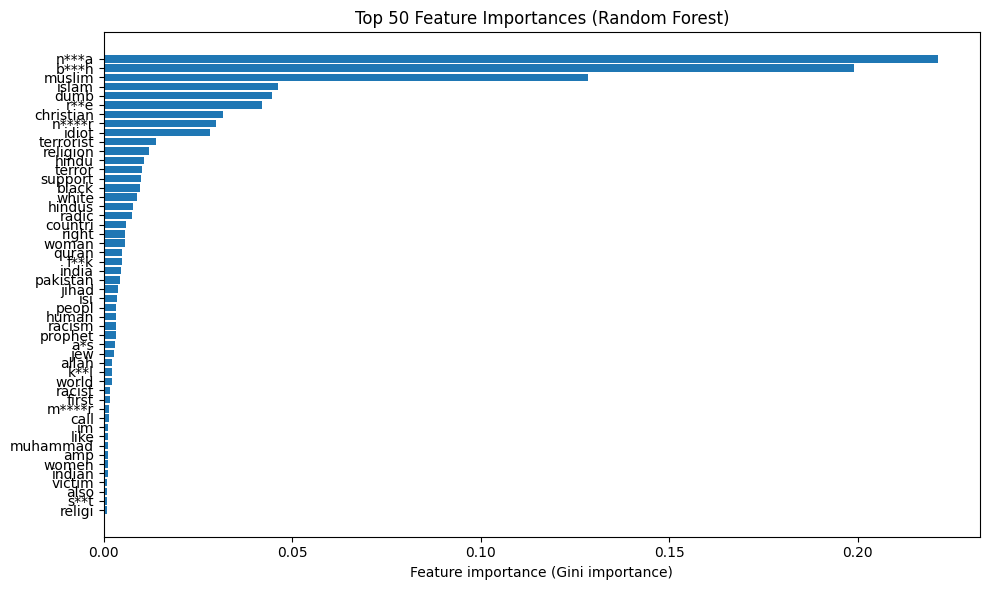

In [10]:
importances = rf_model.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out()

df_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_k = 50
df_top = df_importances.head(top_k)

df_top["feature"] = df_top["feature"].apply(blur_text)

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature importance (Gini importance)")
plt.title("Top 50 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()




## Local Binary Model Explanation

In [11]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

df_correct_examples = pd.read_csv("../dataset/selected_explanable_example.csv")

X_example_tfidf = tfidf_vectorizer_binary.transform(df_correct_examples["text"]).toarray().astype("float32")
feature_names = tfidf_vectorizer_binary.get_feature_names_out() 

for i in range(len(df_correct_examples)):
    label_id = df_correct_examples.loc[i, "label_name"] != 'not_cyberbullying'
    orig_label = df_correct_examples.loc[i, "label_name"]
    label_name = 'cyberbullying' if orig_label != 'not_cyberbullying' else 'not_cyberbullying'
    text = df_correct_examples.loc[i, "text"]
    
    x = X_example_tfidf[i].reshape(1, -1)

    prediction, bias, contributions = ti.predict(rf_binary, x)
    predicted_label_id = np.argmax(prediction)

    data = []
    for j in range(len(feature_names)):
        data.append({
            "feature": blur_text(feature_names[j]),
            "contribution": contributions[0][j][predicted_label_id], 
            "tfidf_value": x[0][j]
        })

    df_interp = pd.DataFrame(data)
    df_interp_sorted = df_interp.reindex(df_interp.contribution.abs().sort_values(ascending=False).index)

    print(f"\n=== TreeInterpreter Explanation ===")
    print(f"True class: {label_id} ({label_name})")
    print(f"Predicted class: {predicted_label_id}")
    print(f"Text preview: {text[:150]}...\n")
    print(f"Bias (expected value): {bias[0][predicted_label_id]:.4f}")
    print(f"Prediction (probabilities): {prediction[0]}")
    
    display(df_interp_sorted.head(25))
    print("=" * 100)


=== TreeInterpreter Explanation ===
True class: True (cyberbullying)
Predicted class: 1
Text preview: dumb nigger fuck...

Bias (expected value): 0.5000
Prediction (probabilities): [0. 1.]


,feature,contribution,tfidf_value
64,dumb,0.280609,0.571965
209,n****r,0.280193,0.631761
92,f**k,0.113529,0.523196
28,b***h,-0.057897,0.000000
208,n***a,-0.041760,0.000000
198,muslim,-0.019050,0.000000
143,islam,-0.008156,0.000000
242,r**e,-0.006893,0.000000
16,a*s,-0.005886,0.000000
136,idiot,-0.004775,0.000000



=== TreeInterpreter Explanation ===
True class: True (cyberbullying)
Predicted class: 1
Text preview: bitch plain simpl everi game shit...

Bias (expected value): 0.5000
Prediction (probabilities): [0. 1.]


,feature,contribution,tfidf_value
28,b***h,0.650657,0.299663
208,n***a,-0.040098,0.000000
96,game,-0.020766,0.562733
198,muslim,-0.020226,0.000000
263,s**t,0.018522,0.552104
143,islam,-0.009710,0.000000
242,r**e,-0.008347,0.000000
16,a*s,-0.006218,0.000000
64,dumb,-0.006129,0.000000
72,everi,0.005763,0.537322



=== TreeInterpreter Explanation ===
True class: True (cyberbullying)
Predicted class: 1
Text preview: visit muslim countri see woke right your behead like british girl idiot thought vacat morocco good idea dont blond err mean stupid...

Bias (expected value): 0.5000
Prediction (probabilities): [0.004 0.996]


,feature,contribution,tfidf_value
198,muslim,0.223717,0.185016
136,idiot,0.179850,0.249513
51,countri,0.090475,0.280160
62,dont,0.038255,0.205185
28,b***h,-0.035453,0.000000
164,like,0.024080,0.185112
208,n***a,-0.021528,0.000000
283,s****d,0.019705,0.320033
250,right,0.015742,0.246141
143,islam,-0.008078,0.000000



=== TreeInterpreter Explanation ===
True class: False (not_cyberbullying)
Predicted class: 0
Text preview:   fact paid fruit cup coffe school insan...

Bias (expected value): 0.5000
Prediction (probabilities): [0.994 0.006]


,feature,contribution,tfidf_value
28,b***h,0.136877,0.000000
208,n***a,0.097041,0.000000
198,muslim,0.042626,0.000000
77,fact,-0.029590,0.701015
242,r**e,0.024839,0.000000
143,islam,0.018342,0.000000
64,dumb,0.016474,0.000000
255,school,0.015322,0.713146
209,n****r,0.014427,0.000000
44,christian,0.010496,0.000000


## Global Binary Model Explanation

/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_2061/1611219305.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top["feature"] = df_top["feature"].apply(blur_text)


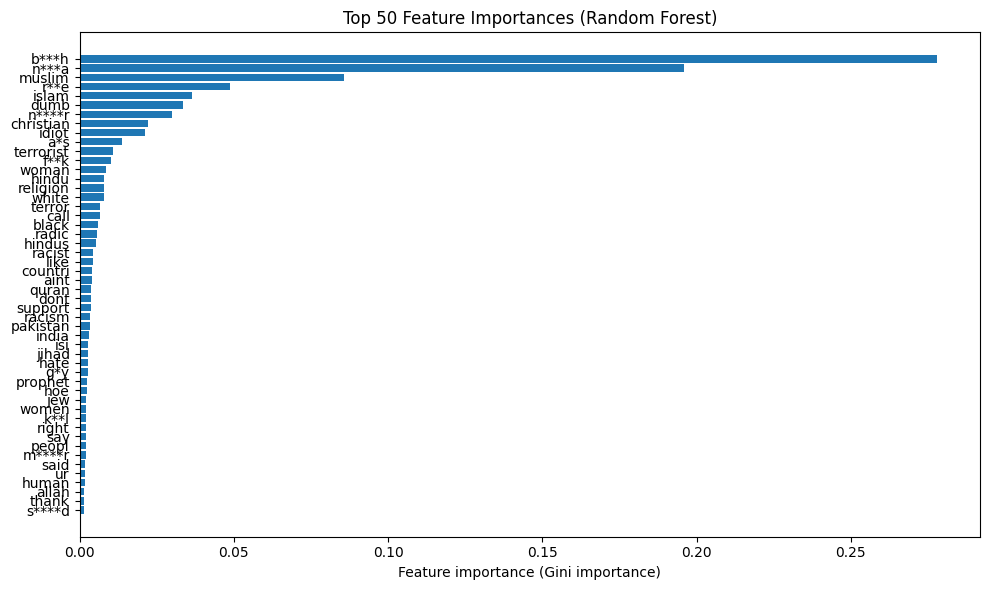

In [12]:
importances = rf_binary.feature_importances_

feature_names = tfidf_vectorizer_binary.get_feature_names_out()

df_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_k = 50
df_top = df_importances.head(top_k)

df_top["feature"] = df_top["feature"].apply(blur_text)

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature importance (Gini importance)")
plt.title("Top 50 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()